In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import dask.dataframe as dd
from dask.diagnostics import ProgressBar

In [ ]:
## LOAD FILES

# df = pd.read_csv('./../../data/processed/_FCPY.csv', nrows = 100000)
df = dd.read_csv('./../../data/processed/_FCPY.csv')

df['PERIOD'] = (df.YEAR - 1997)//6

# df = df.groupby(['IMPORT', 'ID', 'CN ID 4', 'PYOD', 'PERIOD'])[['VART']].mean().reset_index()
with ProgressBar():
    df = df.groupby(['IMPORT', 'ID', 'CN ID 4', 'PYOD', 'PERIOD'])[['VART']].mean().reset_index().compute()


firm_sizes = df.groupby(['IMPORT', 'ID', 'PERIOD'])['VART'].sum().reset_index()
# firm_sizes = pd.read_csv('./../../data/processed/firm_sizes.csv')

df = df.merge(firm_sizes, on = ['IMPORT', 'PERIOD', 'ID'])
df['log_size'] = np.log10(df.VART_y)

df['log_size_bin'] = pd.cut(df['log_size'], np.arange(3, 10, .5))
# # small cases are discarded

# # map LU and BE to XU and regroup.

[####################################### ] | 98% Completed |  1min 47.8s

In [11]:
# Taking count is a shortcut for taking ['ID'].unique(). 
# Think about using gross countries and aggregating into them before the unique count of firms..
info = df.groupby(['IMPORT', 'PERIOD', 'log_size_bin', 'CN ID 4', 'PYOD'])['VART_x'].agg(['count', 'sum']).reset_index()

In [12]:
main_prods = info.groupby(['CN ID 4'])['sum'].sum().sort_values().tail(26).index.values
main_pyods = info.groupby(['PYOD'])['sum'].sum().sort_values().tail(10).index.values

In [13]:
# have a list of countries
main_pyods

#have a list of products
main_prods

# make up plot data:
data = info.loc[info['CN ID 4'].isin(main_prods)]

countries = pd.read_csv('./../../data/c_table.csv')[['Country or area', 'ISO3166-1-Alpha-2']]
name_mapper = countries.set_index('ISO3166-1-Alpha-2').loc[main_pyods].to_dict()['Country or area']
name_mapper['US'] ='United States'; name_mapper['GB']='United Kingdom'

data['Country'] = data['PYOD'].map(name_mapper).fillna('_Rest')

data = data.groupby(['CN ID 4','IMPORT','PERIOD','log_size_bin','Country'])[['count', 'sum']].sum()

In [14]:
# slice_ = data.loc[2204].loc[0].loc[0].sort_index()

# display(slice_['count'].unstack())

# display(slice_['sum'].unstack())

In [15]:
CN_full = pd.read_csv('./../../data/CN_full.csv', encoding = 'utf-8')

6211 Tracksuits, ski suits and swimwear; other garments


KeyError: 1

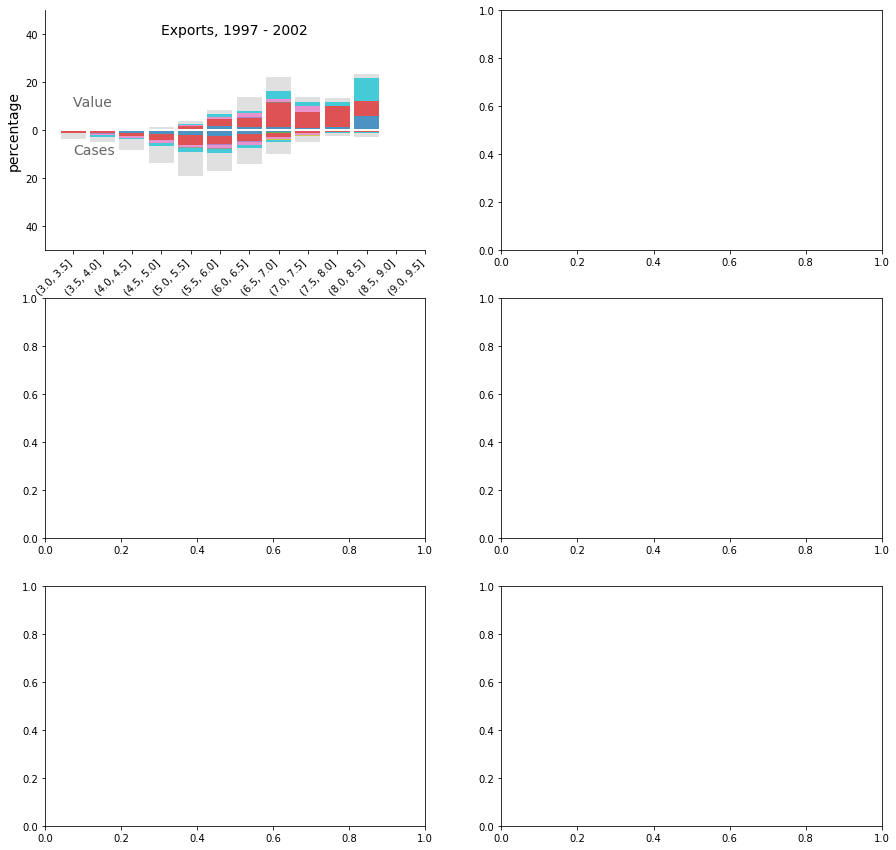

In [16]:
from pylab import *
barWidth = 0.85

import matplotlib.ticker as ticker
@ticker.FuncFormatter
def major_formatter(x, pos):
    label = str(int(round(-x))) if x < 0 else str(int(round(x)))
    return label


for p in main_prods:

    print(p, CN_full.set_index('CN ID 4')[['CN label 4']].drop_duplicates().loc[p]['CN label 4'])


    fig, axs = plt.subplots(3, 2, figsize = (15, 15))
    

    for i in range(2):
        for j in range(3):
            slice_ = data.loc[p].loc[i].loc[j].sort_index()
            ## RIGHT PLOT
            ax = axs[j][i]

            table = slice_.unstack(0, 1)[['sum']]
            bar_ctries = table.index.values

            nrows, nbins = table.shape
            
            cmap = cm.get_cmap('tab10', nrows)
            colors = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
            colors[-1] = '.85'

            for c in range(nrows):
                if c == 0:
                    ax.bar(range(nbins), 100* table.loc[bar_ctries[0]]/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = '_'+bar_ctries[0], color = colors[c], alpha = .8)
                else:
                    ax.bar(range(nbins), 100* table.loc[bar_ctries[c]]/table.sum().sum(), 
                           bottom=100* table.loc[bar_ctries[:c]].sum()/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = '_'+bar_ctries[c], color = colors[c], alpha = .8)
            ax.set_ylim(0, 1)

            ax1 = ax#.twinx()
            ax.set_ylim(-50, 50)

            table = slice_.unstack(0, 1)[['count']].sort_index()
            bar_ctries = table.index.values
            for c in range(nrows):
                if c == 0:
                    ax1.bar(range(nbins), -100* table.loc[bar_ctries[0]]/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = bar_ctries[0], color = colors[c], alpha = .8)
                else:
                    ax1.bar(range(nbins), -100* table.loc[bar_ctries[c]]/table.sum().sum(), 
                           bottom=-100* table.loc[bar_ctries[:c]].sum()/table.sum().sum(), 
                            edgecolor='None', width=barWidth, label = bar_ctries[c], color = colors[c], alpha = .8)
#             ax1.set_ylim(0, -1)
#             ax1.invert_yaxis()

            ax.annotate(['Exports', 'Imports'][i] + ', '+ ['1997 - 2002', '2003 - 2008', '2009 - 2013'][j],
                       xy=(nrows/2., 40), ha = 'center', fontsize = 14)
    
            ax.annotate('Cases', xy=(0, -10), ha = 'left', fontsize = 14, color = '.4')
            ax.annotate('Value', xy=(0, 10), ha = 'left', fontsize = 14, color = '.4')
        
            if i == 1:
                ax.legend(loc = (1.02, 0))
                
            ax.axhline(0, c = 'w', lw = 2)
            ax.yaxis.set_major_formatter(major_formatter) # No negative vals
            
            ax1.set_xticks(range(nbins))
            ax1.set_xticklabels(table.columns.get_level_values(1).astype(str).values, rotation = 45, ha = 'right')
            
            if i == 0: ax.set_ylabel('percentage', fontsize = 14)
            if j == 2: ax.set_xlabel('Firm annual size (log EUR)', fontsize = 14)
                
            # Hide the right and top spines
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.savefig('./../../../WRITING/thesis_writing/figures/xcp_firmsizeBars_p'+str(p)+'.png', bbox_inches='tight')
    plt.show()